# Causal CNN

Causal（adj.因果的）， **Causal CNN（因果卷积神经网络）**

## 1 标准CNN的问题

**序列数据（Sequential Data）** ：

指 **数据点按特定顺序排列，且顺序本身蕴含重要信息** 的数据类型。

其核心特征是： **前后数据点之间存在依赖关系或上下文关联** ，改变顺序会改变数据的含义或破坏其结构。股票价格、句子或段落、DNA序列、音频信息都是序列数据。



标准的卷积层在处理序列数据时，通常使用对称的卷积核，即对于某个隐藏位置应用卷积核时，左右偏移量都存在且相同。例如，一个长度为 $k=3$ 的卷积核在处理隐藏位置 $t$ 时，会同时受到 $t-1, t, t+1$ 的原始数据的影响。 



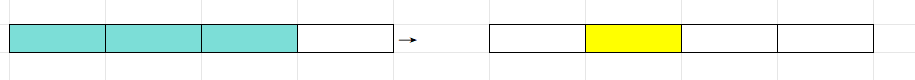

## 2 Causal CNN 的解决方案

因果卷积的核心思想： **确保计算输出 $o_t$ 时，只使用输入 $x_1,x_2,...,x_t$ ，不使用任何 $x_{t+1}, x_{t+2}, ...$** 的信息。

### 单向卷积

例如：对于一维卷积核 $[w_{-1}, w_0, w_1]$ ，在计算 $o_t$ 时，只用 $w_{-1} \times x_{t-1} + w_0 * x_t$ ，而不计算 $w_1 * x_{t+1}$ 的部分。

### 左填充

区别于标准 CNN 的双侧对称填充，Causal CNN 只进行左填充，填充量为 “卷积核大小 - 1” ，这样能保持输出序列长度与输入序列长度相同。

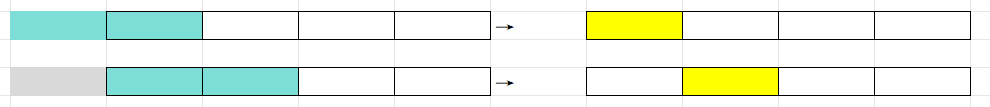

In [2]:
import torch.nn as nn

class MinimalCausalCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.padding = 2  # 对于kernel_size=3
        self.model = nn.Sequential(
            nn.Conv1d(1, 64, 3),  # 输入层
            nn.ReLU(),
            nn.Conv1d(64, 64, 3),  # 隐藏层
            nn.ReLU(),
            nn.Conv1d(64, 1, 1)    # 输出层
        )
    
    def forward(self, x):
        x = nn.functional.pad(x, (self.padding, 0))
        return self.model(x)

# Dilated CNN

**Dilated CNN（扩张卷积神经网络）** ，也称为空洞卷积或带孔卷积，是一种特殊类型的卷积操作，它在标准卷积核的元素之间插入空隙（dilation）来扩大感受野，同时不增加参数数量或计算复杂度。

**扩张率（Delation Rate）** ：

定义卷积核元素之间的间隔，如标准卷积的扩张率 $r=1$ 表示无间隔，扩张率 $r=2$ 表示元素之间有一个元素的间隔。

**感受野（Receptive Field）** ：

输入空间中影响特征图中特定神经元输出的区域大小。

扩张卷积可以指数级地扩大感受野，感受野计算公式为：

$$RF_{new} = RF_{prev} + (k - 1) \times r \times RF_{prev}$$




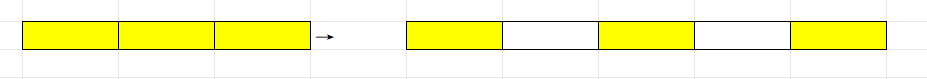

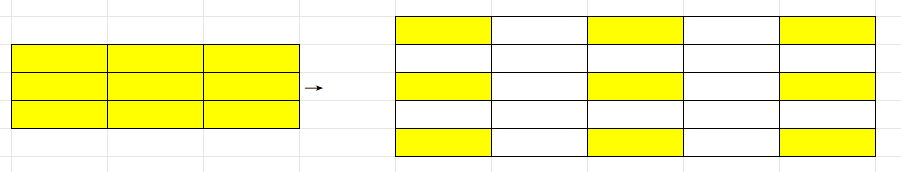

In [1]:
import torch.nn as nn

# 扩张卷积层
dilated_conv = nn.Conv2d(
    in_channels=64,
    out_channels=64,
    kernel_size=3,
    dilation=2,  # 扩张率=2
    padding=2    # 保持空间尺寸：padding = dilation * (kernel_size - 1) // 2
)

# 多层扩张卷积网络
class DilatedCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, dilation=2, padding=2),  # r=2
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, dilation=4, padding=4),  # r=4
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, dilation=8, padding=8),  # r=8
            nn.ReLU(),
            nn.Conv2d(64, 10, 1)  # 1×1卷积输出
        )
    
    def forward(self, x):
        return self.net(x)

# Transposed CNN 

**Transposed CNN(转置卷积神经网络)** ，也被称为反卷积（Deconvolution）或分数步长卷积（Fractionally-strided Convolution）。

## 1 与常规卷积的对比

在标准卷积神经网络中，我们通过卷积和池化操作降低特征图的空间维度。例如：

$$
\text{输入(224×224) → 卷积 → 池化 → (112×112) → 卷积 → 池化 → (56×56)}
$$

但是对于图像分割、生成等任务，需要恢复原始分辨率，例如：

$$
\text{低分辨率特征(56×56) → 上采样 → 高分辨率输出(224×224)}
$$

## 2 上采样

**上采样（Upsampling）** ：

深度学习中的一种 **增加数据空间分辨率的技术** 。其主要方法有：


#### 传统插值方法

最近邻插值：

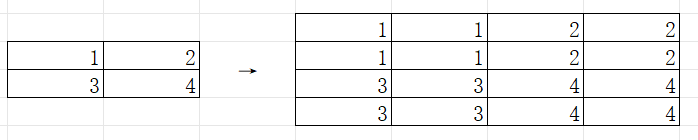

双线性插值：

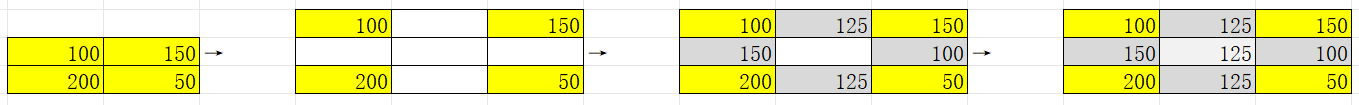

双三次插值：

常用双三次基函数计算权重，这里不作要求。

以上插值方法均有对应的 Pytorch 实现。

#### 学习型上采样方法

转置卷积即是常用的学习型上采样方法。

## 3 转置卷积原理

转置卷积的核心原理是： 

**每个输入元素乘以卷积核，并将结果添加到输出特征图的对应位置，如果位置重叠，则值相加** 。

转置卷积通过 “分散” 输入值到更大的输出区域来实现上采样。每个输入元素被卷积核缩放后，放置到输出中由步长决定的起始位置，并覆盖一个与卷积核相同大小的区域。重叠区域的值相加，这类似于卷积操作中梯度反向传播的过程。

**输出尺寸计算公式** ：

$$
输出宽度 = (输入宽度 - 1) \times 步长 + 卷积核宽度
$$

$$
输出高度 = (输入高度 - 1) \times 步长 + 卷积核高度
$$

**操作过程** ：

1. 计算输出尺寸，并初始化输出矩阵，所有元素为0
2. 遍历输入矩阵的每个元素
3. 对于每个输入元素，将其值乘以卷积核
4. 将每个输入元素对应的矩阵添加到输出矩阵的对应位置：起始位置由输入元素的位置和步长决定（ $i \times stride, j \times stride$ ）
5. 如果多个输入元素的添加区域重叠，则重叠位置的值相加

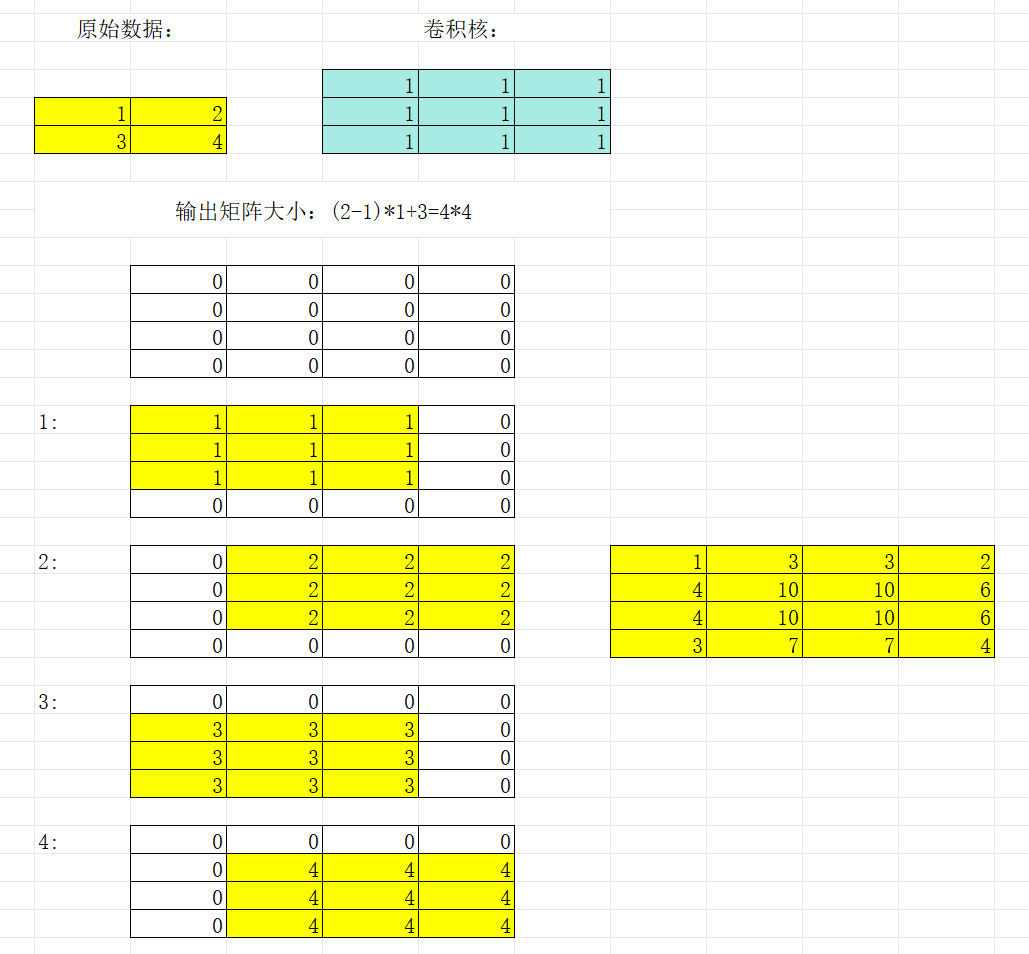

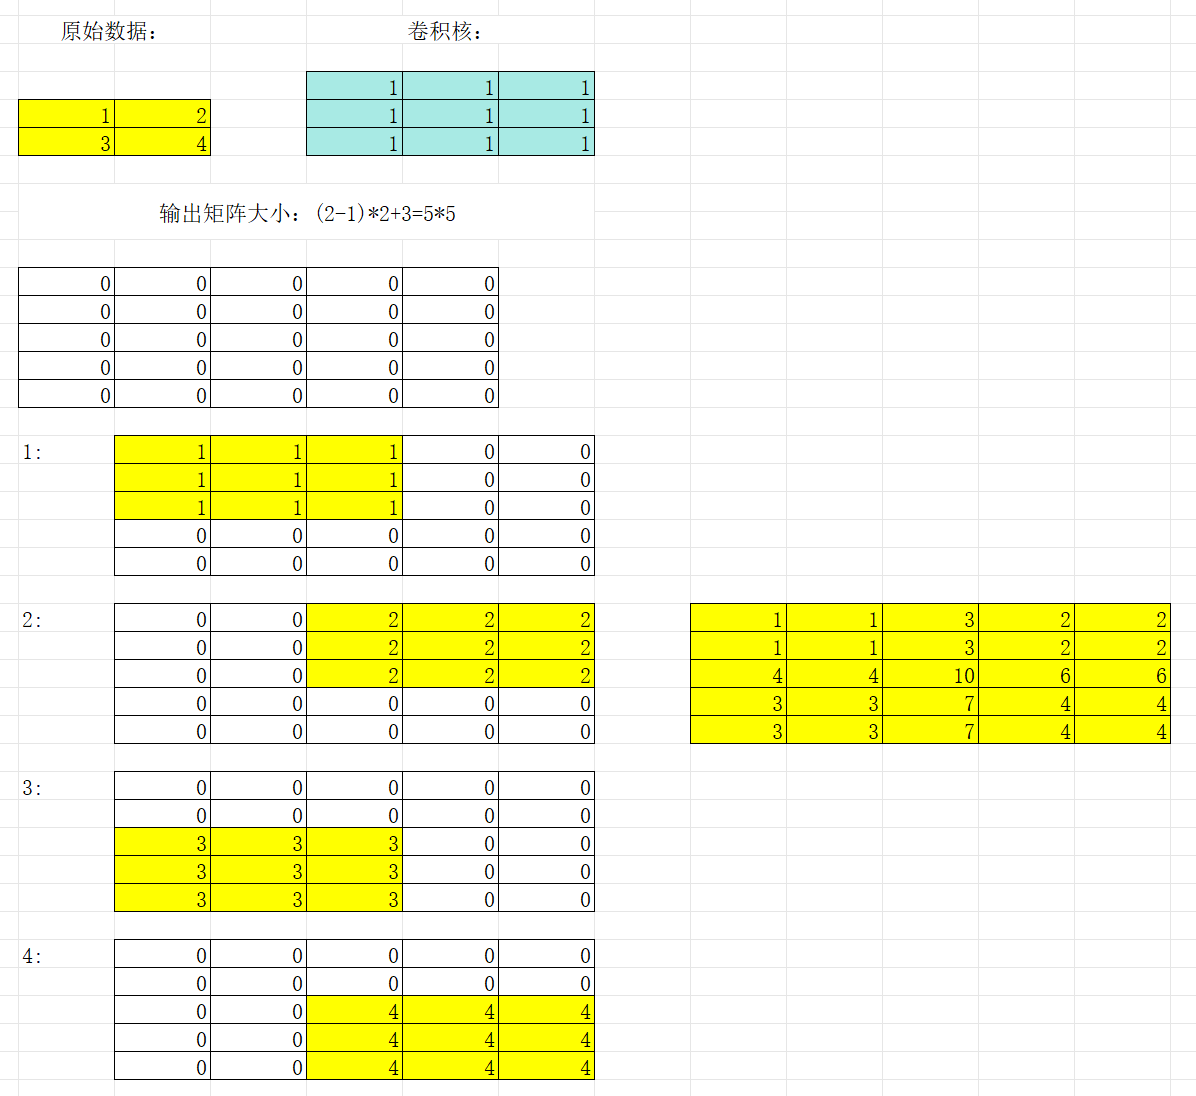

# U-Net

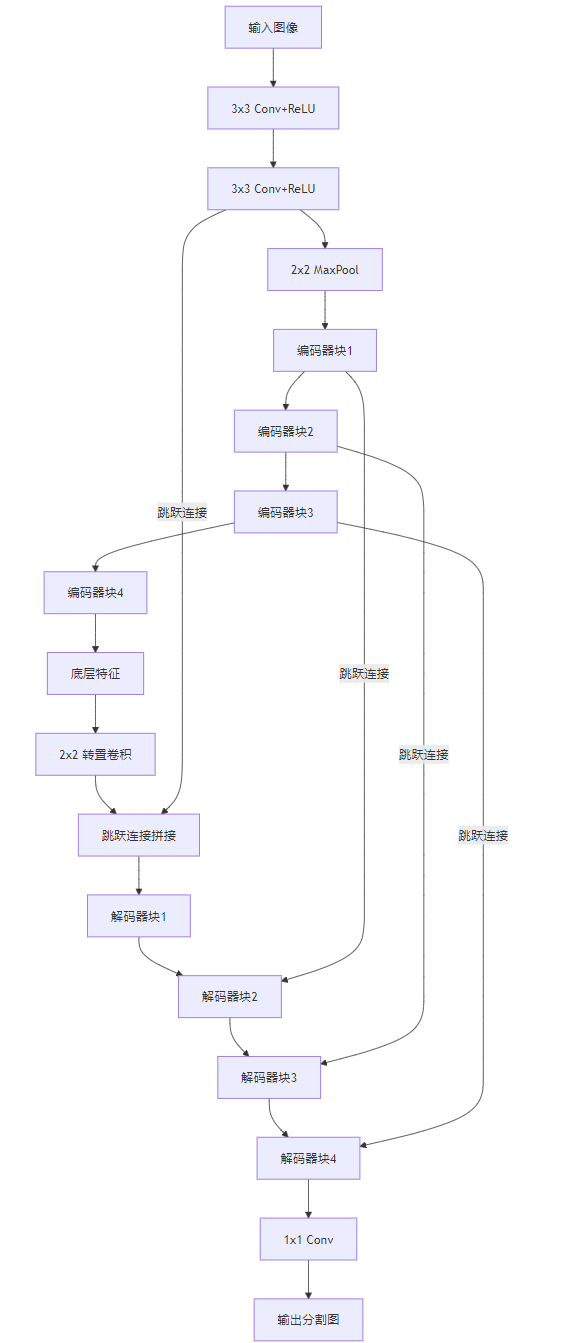



## 核心设计特点

**U 形对称结构** ：
   - **编码器（左侧下行路径）**：
     - 通过卷积和池化逐步提取高级语义特征
     - 特征图尺寸减小（下采样），通道数增加
   - **解码器（右侧上行路径）**：
     - 通过转置卷积（上采样）恢复空间分辨率
     - 特征图尺寸增大，通道数减少

**跳跃连接（Skip Connections）** ：
   - 核心创新：将编码器的特征图与解码器的特征图**跨层连接**
   - 操作方式：通道维度拼接（concatenation）
   - 作用：
     - 保留低级视觉细节（边缘、纹理）
     - 解决深层网络信息丢失问题
     - 实现精确定位

**全卷积设计** ：
   - 无全连接层，可处理任意尺寸输入
   - 输出与输入尺寸相近的分割掩码

